## Setup

In [28]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud as WC
from wordcloud import STOPWORDS
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabriellahurtado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [2]:
fake=pd.read_csv('fake_tokens.csv')
fake=fake.rename(columns={'Unnamed: 0':'index'})
real=pd.read_csv('real_tokens.csv')
real=real.rename(columns={'Unnamed: 0':'index'})
full_df=real.append(fake,sort=False)
full_df['filtered_tokens']=full_df['filtered_tokens'].apply(lambda x: x.replace(' ',""))

In [3]:
valid=pd.read_csv('dev.csv')
val_x=valid.drop(['label'],axis=1)
val_y=valid['label']

In [4]:
x=full_df.drop(['label'],axis=1)
y=full_df['label']

## Featurizing

### Bag of words model

In [5]:
bow_vectorizer = CountVectorizer(stop_words='english', binary=True)
bow_vectorizer.fit(full_df['review'])
bow_x_train = bow_vectorizer.transform(x['review'])

### Bag of Bi-grams model

In [6]:
bv2 = CountVectorizer(stop_words='english', binary=True, ngram_range=(2,2))
bv2.fit(full_df['review'])
bv2_x_train = bv2.transform(x['review'])

### TF-IDF model

In [7]:
tv = TfidfVectorizer()
tv.fit(full_df['review'])
tv_x_train = tv.transform(x['review'])

## Balancing 

In [208]:
print('number of real reviews:',(len(real)))
print('number of fake reviews:',(len(fake)))

number of real reviews: 225055
number of fake reviews: 25819


In [8]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Undersampling

In [9]:
#BOW
rus=RandomUnderSampler()
under_x, under_y = rus.fit_sample(bow_x_train, y)

In [10]:
#Bi-grams
under_x_bv2, under_y_bv2=rus.fit_sample(bv2_x_train, y)

In [11]:
#TF-IDF
under_x_tv, under_y_tv=rus.fit_sample(tv_x_train, y)

### SMOTE

In [12]:
#BOW
sm=SMOTE()
over_x, over_y = sm.fit_sample(bow_x_train, y)

In [13]:
#Bi-grams
over_x_bv2, over_y_bv2 = sm.fit_sample(bv2_x_train, y)

In [14]:
#TF-IDF
over_x_tv, over_y_tv = sm.fit_sample(tv_x_train, y)

## Tuning

In [23]:
from sklearn.metrics import roc_curve, auc

In [117]:
rf1=RandomForestClassifier()

In [20]:
bow_x_val=bow_vectorizer.transform(valid['review'])

In [16]:
#taken from Amelia!
def ClassifierMetrics (X_train, Y_train, X_test, Y_test, fitted_model):
    Y_pred = fitted_model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    metrics = {'train_accuracy': fitted_model.score(X_train, Y_train),
    'test_accuracy': fitted_model.score(X_test, Y_test),
    'test_tpr': tpr,
    'test_fpr': fpr,
    'test_auc': roc_auc_score(Y_test, Y_pred),
    'test_ap': average_precision_score(Y_test, Y_pred)}
    return metrics

### Baseline

In [118]:
bow_rf_base=rf1.fit(over_x,over_y)
eval_bow_rf=ClassifierMetrics(bow_x_train,y,bow_x_val,val_y,
                              bow_rf_base)
eval_bow_rf

{'train_accuracy': 0.9823018726532043,
 'test_accuracy': 0.8940364162815302,
 'test_tpr': array([0.        , 0.04632675, 1.        ]),
 'test_fpr': array([0.        , 0.01013325, 1.        ]),
 'test_auc': 0.5180967518443614,
 'test_ap': 0.11264423408437553}

### Max_depth

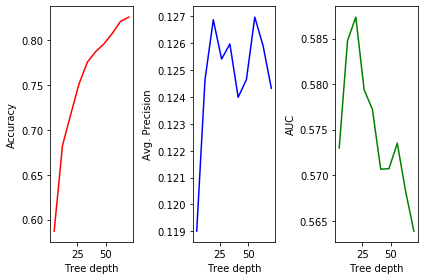

In [152]:
max_depths = np.linspace(5, 70, 10, endpoint=True)
accuracies = [0]*len(max_depths)
aps = [0]*len(max_depths)
aucs = [0]*len(max_depths)
for i in range(len(max_depths)):
    rf = RandomForestClassifier(max_depth=max_depths[i])
    rf.fit(over_x,over_y)
    preds = rf.predict(bow_x_val)
    accuracy=rf.score(bow_x_val,val_y)
    accuracies[i]=accuracy 
    ap=average_precision_score(val_y, preds)
    aps[i]=ap
    auc=roc_auc_score(val_y, preds)
    aucs[i]=auc
    
plt.subplot(1, 3, 1)
plt.plot(max_depths, accuracies, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')


plt.subplot(1, 3, 2)
plt.plot(max_depths, aps,'b')
plt.ylabel('Avg. Precision')
plt.xlabel('Tree depth')

plt.subplot(1, 3, 3)
plt.plot(max_depths, aucs,'g')
plt.ylabel('AUC')
plt.xlabel('Tree depth')

plt.tight_layout()
plt.show()

In [153]:
accuracies

[0.5872543014644468,
 0.6826660727211983,
 0.7174675650091876,
 0.7514338214822651,
 0.7755164541455538,
 0.7872932791358094,
 0.7959240492232307,
 0.8075059858566735,
 0.820981123670583,
 0.8257698090094103]

In [154]:
aps

[0.11900741970180483,
 0.12464294035546003,
 0.12687387386404902,
 0.1254116939087099,
 0.12597368352824218,
 0.12398597002966819,
 0.12465425927697091,
 0.12697394299541034,
 0.1259113799418796,
 0.12432495254020479]

In [155]:
aucs

[0.5729940275716406,
 0.5847600546240873,
 0.587351623704054,
 0.5793882924502144,
 0.5772302400524087,
 0.5706550643148001,
 0.5707171688032445,
 0.5735157698340211,
 0.5682504457999662,
 0.5638645658343255]

In [156]:
max_depths

array([ 5.        , 12.22222222, 19.44444444, 26.66666667, 33.88888889,
       41.11111111, 48.33333333, 55.55555556, 62.77777778, 70.        ])

### Min_samples_split

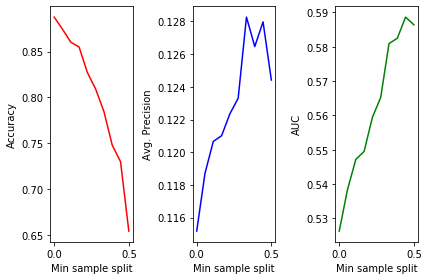

In [133]:
min_samples_splits = np.linspace(0.001, 0.5, 10, endpoint=True)
accuracies2 = [0]*len(min_samples_splits)
aps2 = [0]*len(min_samples_splits)
aucs2= [0]*len(min_samples_splits)
for i in range(len(min_samples_splits)):
    rf = RandomForestClassifier(min_samples_split=min_samples_splits[i])
    rf.fit(over_x,over_y)
    preds = rf.predict(bow_x_val)
    accuracy=rf.score(bow_x_val,val_y)
    accuracies2[i]=accuracy
    ap=average_precision_score(val_y, preds)
    aps2[i]=ap
    auc=roc_auc_score(val_y, preds)
    aucs2[i]=auc
    
plt.subplot(1, 3, 1)
plt.plot(min_samples_splits, accuracies2, 'r')
plt.ylabel('Accuracy')
plt.xlabel('Min sample split')


plt.subplot(1, 3, 2)
plt.plot(min_samples_splits, aps2,'b')
plt.ylabel('Avg. Precision')
plt.xlabel('Min sample split')

plt.subplot(1, 3, 3)
plt.plot(min_samples_splits, aucs2,'g')
plt.ylabel('AUC')
plt.xlabel('Min sample split')

plt.tight_layout()
plt.show()

In [132]:
accuracies2

[0.8925886742023498,
 0.8820925441282922,
 0.8802828665293168,
 0.8778050002784119,
 0.8772481764018041,
 0.8739629155298179,
 0.8723202850938249,
 0.8681441060192661,
 0.8685895651205524,
 0.8621860905395623]

In [127]:
aps2

[0.11350906948480272,
 0.11544758789799502,
 0.11661088962773666,
 0.11935362858035806,
 0.11988268724315877,
 0.12011144807448376,
 0.11919722412627567,
 0.12070809147541492,
 0.12096396564397677,
 0.119771640518652]

In [141]:
aucs2

[0.5262785998347279,
 0.538416047575555,
 0.5471686690288627,
 0.5494986279418721,
 0.559442880859959,
 0.5652218177629541,
 0.5809286383665236,
 0.5824822444533242,
 0.5886568712997243,
 0.5864174739995325]

In [142]:
max(aucs2)

0.5886568712997243

In [147]:
min_samples_splits[8]*over_x.shape[0]

200098.9011111111

In [148]:
min_samples_splits[8]

0.44455555555555554

## Evaluation

In [157]:
rf=RandomForestClassifier(max_depth=20,min_samples_split=0.44)

### Bag of Words Evaluation

#### BOW unbalanced

In [158]:
#unbalanced
bow_rf_train=rf.fit(bow_x_train,y)
eval_bow_rf=ClassifierMetrics(bow_x_train,y,bow_x_val,val_y,
                              bow_rf_train)

In [159]:
eval_bow_rf

{'train_accuracy': 0.8970837950524965,
 'test_accuracy': 0.898435324906732,
 'test_tpr': array([0., 1.]),
 'test_fpr': array([0., 1.]),
 'test_auc': 0.5,
 'test_ap': 0.101564675093268}

#### BOW undersampled

In [160]:
#unbalanced
bow_rf_under=rf.fit(under_x,under_y)
eval_bow_rf_under=ClassifierMetrics(under_x,under_y,bow_x_val,val_y,
                              bow_rf_under)
eval_bow_rf_under

{'train_accuracy': 0.6184980053449011,
 'test_accuracy': 0.547441394286987,
 'test_tpr': array([0.       , 0.6935307, 1.       ]),
 'test_fpr': array([0.        , 0.46907344, 1.        ]),
 'test_auc': 0.6122286294641158,
 'test_ap': 0.1304434114827363}

#### BOW oversampled

In [161]:
#oversampled
bow_rf_over=rf.fit(over_x,over_y)
eval_bow_rf_over=ClassifierMetrics(over_x,over_y,bow_x_val,val_y,
                              bow_rf_over)
eval_bow_rf_over

{'train_accuracy': 0.828670769367488,
 'test_accuracy': 0.7068043877721477,
 'test_tpr': array([0.        , 0.42598684, 1.        ]),
 'test_fpr': array([0.        , 0.26145026, 1.        ]),
 'test_auc': 0.5822682893513611,
 'test_ap': 0.12455744733270427}

### Bag of Bi-grams Evaluation

In [162]:
bv2_x_val=bv2.transform(valid['review'])

#### Bi-gram unbalanced

In [163]:
#unbalanced
bv2_rf_train =rf.fit(bv2_x_train,y)
eval_bv2_rf=ClassifierMetrics(bv2_x_train, y, bv2_x_val, val_y, 
                              bv2_rf_train)

eval_bv2_rf

{'train_accuracy': 0.8970837950524965,
 'test_accuracy': 0.898435324906732,
 'test_tpr': array([0., 1.]),
 'test_fpr': array([0., 1.]),
 'test_auc': 0.5,
 'test_ap': 0.101564675093268}

#### Bi-gram undersampled

In [164]:
#undersampled
bv2_rf_under=rf.fit(under_x_bv2,under_y_bv2)
eval_bv2_rf_under=ClassifierMetrics(under_x_bv2, under_y_bv2, 
                                    bv2_x_val, val_y, bv2_rf_under)

eval_bv2_rf_under

{'train_accuracy': 0.5542236337580851,
 'test_accuracy': 0.264435659001058,
 'test_tpr': array([0.        , 0.89912281, 1.        ]),
 'test_fpr': array([0.        , 0.80731329, 1.        ]),
 'test_auc': 0.5459047564681769,
 'test_ap': 0.11078840697098402}

#### Bi-gram oversampled

In [165]:
#oversampled
bv2_rf_over=rf.fit(over_x_bv2,over_y_bv2)
eval_bv2_rf_over=ClassifierMetrics(over_x_bv2, over_y_bv2, bv2_x_val, 
                                   val_y, bv2_rf_over)

eval_bv2_rf_over

{'train_accuracy': 0.6532780875785918,
 'test_accuracy': 0.37468678656940807,
 'test_tpr': array([0.        , 0.73245614, 1.        ]),
 'test_fpr': array([0.        , 0.66575767, 1.        ]),
 'test_auc': 0.5333492353443261,
 'test_ap': 0.10819315781207456}

### TF-IDF Evaluation

In [166]:
tv_x_val=tv.transform(valid['review'])

#### TF-IDF unbalanced

In [167]:
#unbalanced
tv_rf_train = rf.fit(tv_x_train,y)
eval_tv_rf=ClassifierMetrics(tv_x_train, y, tv_x_val, val_y, 
                             tv_rf_train)
eval_tv_rf

{'train_accuracy': 0.8970837950524965,
 'test_accuracy': 0.898435324906732,
 'test_tpr': array([0., 1.]),
 'test_fpr': array([0., 1.]),
 'test_auc': 0.5,
 'test_ap': 0.101564675093268}

#### TF-IDF undersampled

In [168]:
#undersampled
tv_rf_under=rf.fit(under_x_tv,under_y_tv)
eval_tv_rf_under=ClassifierMetrics(under_x_tv, under_y_tv, 
                                    tv_x_val, val_y, tv_rf_under)

eval_tv_rf_under

{'train_accuracy': 0.6095317401913319,
 'test_accuracy': 0.5681830836906286,
 'test_tpr': array([0.        , 0.65186404, 1.        ]),
 'test_fpr': array([0.        , 0.44127673, 1.        ]),
 'test_auc': 0.6052936537384676,
 'test_ap': 0.1286386552811332}

#### TF-IDF oversampled

In [169]:
#oversampled
tv_rf_over=rf.fit(over_x_tv,over_y_tv)
eval_tv_rf_over=ClassifierMetrics(over_x_tv, over_y_tv, tv_x_val, 
                                  val_y, tv_rf_over)

eval_tv_rf_over

{'train_accuracy': 0.694074781720024,
 'test_accuracy': 0.6671306865638399,
 'test_tpr': array([0.        , 0.47889254, 1.        ]),
 'test_fpr': array([0.        , 0.31158971, 1.        ]),
 'test_auc': 0.5836514160265088,
 'test_ap': 0.12381454144266438}

In [170]:
model_names=['Bag of Words (Unbalanced)','Bag of Words (Undersampled)',
             'Bag of Words (Oversampled)', 'Bi-grams (Unbalanced)',
             'Bi-grams (Undersampled)','Bi-grams (Oversampled)',
             'TF-IDF (Unbalanced)','TF-IDF (Undersampled)','TF-IDF (Oversampled)']

test_accs=[eval_bow_rf['test_accuracy'], eval_bow_rf_under['test_accuracy'], 
eval_bow_rf_over['test_accuracy'],eval_bv2_rf['test_accuracy'],
eval_bv2_rf_under['test_accuracy'],eval_bv2_rf_over['test_accuracy'],
eval_tv_rf['test_accuracy'],eval_tv_rf_under['test_accuracy'], 
eval_tv_rf_over['test_accuracy']]

test_tprs=[eval_bow_rf['test_tpr'], eval_bow_rf_under['test_tpr'], eval_bow_rf_over['test_tpr'],
eval_bv2_rf['test_tpr'],eval_bv2_rf_under['test_tpr'],eval_bv2_rf_over['test_tpr'],
eval_tv_rf['test_tpr'],eval_tv_rf_under['test_tpr'], eval_tv_rf_over['test_tpr']]

test_fprs=[eval_bow_rf['test_fpr'], eval_bow_rf_under['test_fpr'], eval_bow_rf_over['test_fpr'],
eval_bv2_rf['test_fpr'],eval_bv2_rf_under['test_fpr'],eval_bv2_rf_over['test_fpr'],
eval_tv_rf['test_fpr'],eval_tv_rf_under['test_fpr'], eval_tv_rf_over['test_fpr']]

test_aucs=[eval_bow_rf['test_auc'], eval_bow_rf_under['test_auc'], eval_bow_rf_over['test_auc'],
eval_bv2_rf['test_auc'],eval_bv2_rf_under['test_auc'],eval_bv2_rf_over['test_auc'],
eval_tv_rf['test_auc'],eval_tv_rf_under['test_auc'], eval_tv_rf_over['test_auc']]

test_aps=[eval_bow_rf['test_ap'], eval_bow_rf_under['test_ap'], eval_bow_rf_over['test_ap'],
eval_bv2_rf['test_ap'],eval_bv2_rf_under['test_ap'],eval_bv2_rf_over['test_ap'],
eval_tv_rf['test_ap'],eval_tv_rf_under['test_ap'], eval_tv_rf_over['test_ap']]

data={'Model':model_names,'Test Accuracy':test_accs,'Test TPR':test_tprs,
      'Test FPR':test_fprs,'Test AUC':test_aucs, 'Test AP':test_aps}
evals=pd.DataFrame(data)
evals

,Model,Test Accuracy,Test TPR,Test FPR,Test AUC,Test AP
0,Bag of Words (Unbalanced),0.898435,"[0.0, 1.0]","[0.0, 1.0]",0.500000,0.101565
1,Bag of Words (Undersampled),0.547441,"[0.0, 0.6935307017543859, 1.0]","[0.0, 0.4690734428261543, 1.0]",0.612229,0.130443
2,Bag of Words (Oversampled),0.706804,"[0.0, 0.42598684210526316, 1.0]","[0.0, 0.26145026340254107, 1.0]",0.582268,0.124557
3,Bi-grams (Unbalanced),0.898435,"[0.0, 1.0]","[0.0, 1.0]",0.500000,0.101565
4,Bi-grams (Undersampled),0.264436,"[0.0, 0.8991228070175439, 1.0]","[0.0, 0.80731329408119, 1.0]",0.545905,0.110788
5,Bi-grams (Oversampled),0.374687,"[0.0, 0.7324561403508771, 1.0]","[0.0, 0.6657576696622249, 1.0]",0.533349,0.108193
6,TF-IDF (Unbalanced),0.898435,"[0.0, 1.0]","[0.0, 1.0]",0.500000,0.101565
7,TF-IDF (Undersampled),0.568183,"[0.0, 0.6518640350877193, 1.0]","[0.0, 0.441276727610784, 1.0]",0.605294,0.128639
8,TF-IDF (Oversampled),0.667131,"[0.0, 0.47889254385964913, 1.0]","[0.0, 0.31158971180663153, 1.0]",0.583651,0.123815
